In [ ]:
# TODO: Add the references
# TODO: Add Twitter accounts or emails?

### Analyzing firefigther calls 

If you are interesting in the project, please, either fork it and submit a pull request, or contact us via Twitter or email.

_Igor Nikolic, Trivik Verma and Mikhail Sirenko_

#### Introduction

The New Year's Eve period has recently become quite controversial for the Netherlands. People living in the largest cities of the country split in two groups and the reason for that: fireworks. The first one arguing in favor of doing fireworks, since it is a tradition. The second suggesting banning it because of the damage. 

In this project we analyzed open data on __firefighter calls__ downloaded/scraped from two websites: … (). These websites, in their turn, collected the data from national emergency network called __P2000__.

The main goals are:
* first, visualize the data in insightful way, 
* second, try to analyze the connection between firefighter calls and fireworks, 
* and finally, discuss amount potentially made damage.

The project outline is straightforward:<br>
<br> a). we load the data and make sure that it is correctly geographically allocated
<br> b). select the period and plot it
<br> c). display calls on map
<br> d). categorize calls by corresponding message and visualize them

#### a). Load the data and check coordinates

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
import contextily as ctx

# from src.data.prepare_data import prepare_gdf, select_ny

In [2]:
# Load the data
data = pd.read_csv("../data/processed/den_haag_ff_calls.csv")
print(f"Total number of records collected : {data.shape[0]}")

# Format the pmeTimeStamp column
data["pmeTimeStamp"] = pd.to_datetime(data["pmeTimeStamp"])

Total number of records collected : 25374


In [5]:
gdf = prepare_gdf(data)

Total number of records collected with assigned coordinates : 25374


In [6]:
# Load municipal borders
polygon = gpd.read_file('../data/processed/den_haag_borders.json', driver="GeoJSON")

In [7]:
%%time
# Select the calls that were made from the city area
mask = gdf.within(polygon["geometry"].iloc[0])
print(f"Total number of records collected with assigned coordinates : {gdf.shape[0]}")
print(f"Number of records within Den Haag municipal border : {gdf.loc[mask].shape[0]}")

Total number of records collected with assigned coordinates : 25374
Number of records within Den Haag municipal border : 24756
Wall time: 34 s


In [8]:
# Select only those that are within Den Haag municipal bodrer 
gdf = gdf.loc[mask]
df = data.loc[mask]

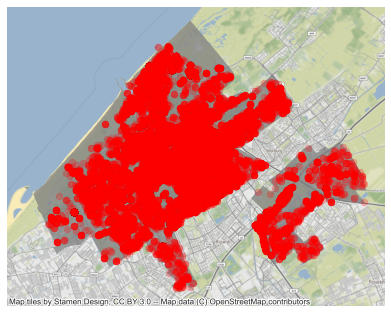

In [11]:
# Inspect correctness visualy
ax = polygon.to_crs(epsg=3857).plot(color='gray', alpha=.75)
gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=.25);
ctx.add_basemap(ax=ax)
plt.axis('off');

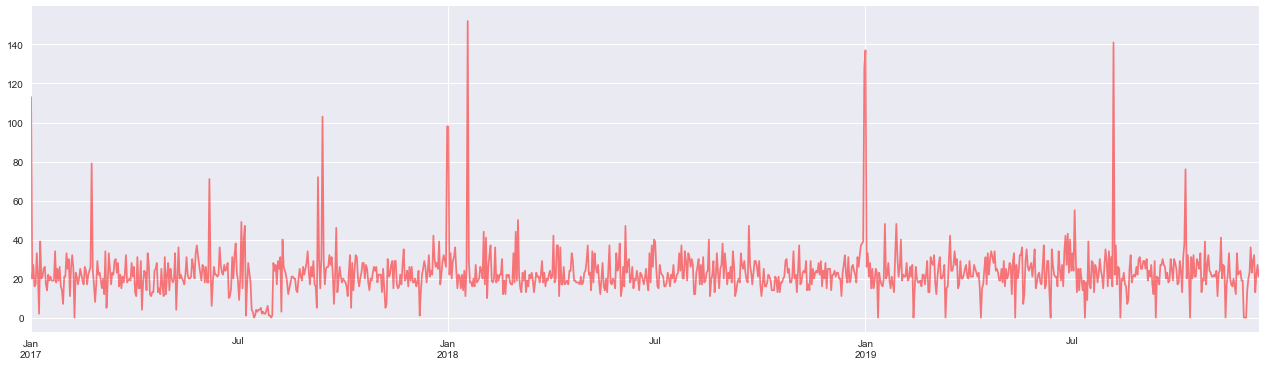

In [10]:
# Plot the data
ax = df.set_index('pmeTimeStamp').groupby(pd.Grouper(freq='D')).count()['pmeId'].plot(figsize=(22,6), color='red', alpha=.5)
ax.set_xlabel("");

#### b). Select the period for analysis

In [31]:
ny_2017 = select_ny(df, year=2017, delta=3)
ny_2018 = select_ny(df, year=2018)
ny_2019 = select_ny(df, year=2019)

The number of firefigthers calls made from 2017-01-01 00:00:00 to 2017-01-03 00:00:00 : 133
The number of firefigthers calls made from 2017-12-30 00:00:00 to 2018-01-02 00:00:00 : 222
The number of firefigthers calls made from 2018-12-30 00:00:00 to 2019-01-02 00:00:00 : 304


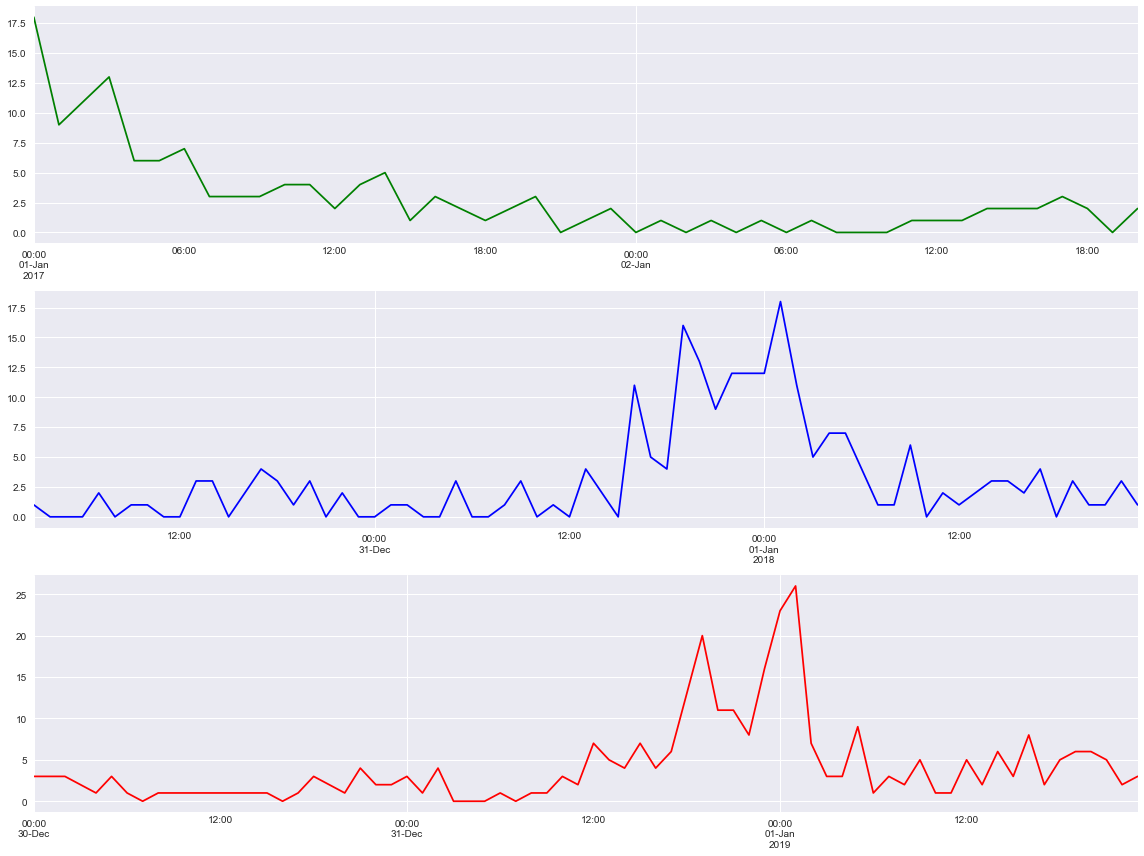

In [32]:
# Plot it
fig, ax = plt.subplots(nrows=3, figsize=(16,12))
ny_2017.set_index('pmeTimeStamp').groupby(pd.Grouper(freq='H')).count()['pmeId'].plot(color='green', ax=ax[0])
ax[0].set_xlabel('')

ny_2018.set_index('pmeTimeStamp').groupby(pd.Grouper(freq='H')).count()['pmeId'].plot(color='blue', ax=ax[1])
ax[1].set_xlabel('')

ny_2019.set_index('pmeTimeStamp').groupby(pd.Grouper(freq='H')).count()['pmeId'].plot(color='red', ax=ax[2])
ax[2].set_xlabel('');

fig.tight_layout()

#### c). Check the calls by type

Unique categories (I did a manual check, maybe missed something):

* Buitenbrand afval/rommel = External fire waste
* Brandmelding Melding Via Openbaar = Meldsysteem Fire Reporting Via Public Reporting System
* Ongeval spoorvervoer letsel = Rail accident injury
* Gebouwbrand woning = Building fire house
* Assistentie ambu = Assistance ambulance
* Assistentie politie = Assistance police
* Stormschade = Storm damage
* Wateroverlast = Waterlogging 
* Liftopsluiting = Lift confinement
* Buitenbrand container = Outdoor fire container
* Persoon te water = Person in the water
* Voertuigbrand = Vehicle fire
* Dienstverlening = Services

In [26]:
gdf = select_ny(df, 2017)

The number of firefigthers calls made from 2017-01-01 00:00:00 to 2017-01-01 00:00:00 : 0


In [1]:
# Specify the categories of interest
categories = ['Buitenbrand afval/rommel', 'Gebouwbrand woning', 'Buitenbrand container', 'Voertuigbrand']

In [12]:
# Select only the calls due to Vehicle Fire
i = []
for index, row in gdf['pmeStrippedMessage'].iteritems():
    if 'Voertuigbrand' in row:
        i.append(index)

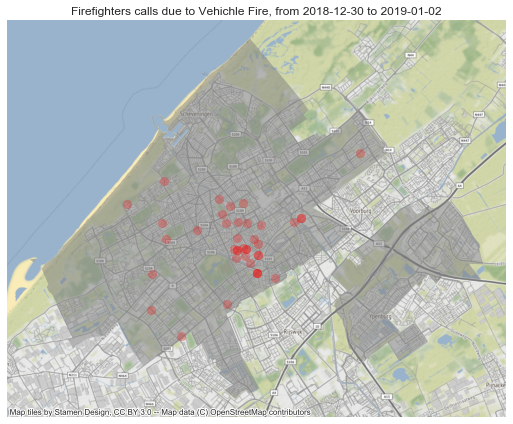

In [13]:
# Plot it
ax = polygon.to_crs(epsg=3857).plot(color='gray', alpha=.5, figsize=(8,6))
gdf.loc[i,:].to_crs(epsg=3857).plot(ax=ax, color='red', alpha=.25, markersize=75);
ctx.add_basemap(ax=ax) # url=ctx.sources.ST_TONER_BACKGROUND)
ax.set_title(f'Firefighters calls due to Vehichle Fire, from {begin.date()} to {end.date()}')
plt.axis('off')
plt.tight_layout();

In [14]:
# Get the rest categories
j = []
for index, row in gdf['pmeStrippedMessage'].iteritems():
    for category in categories:
        if category in row:
            j.append(index)
            break

In [15]:
# Save the data
gdf.loc[j,:].to_file(f'../data/processed/den_haag_ff_calls_cleaned_{year}.json', driver='GeoJSON')

In [16]:
# Display calls by category
df = pd.DataFrame(gdf[['pmeTimeStamp', 'pmeStrippedMessage']].loc[j,:])
l = []
for message in df['pmeStrippedMessage'].tolist():
    for category in categories:
        if category in message:
            l.append(category)
            break

In [17]:
df['pmeCategoryOnly'] = l

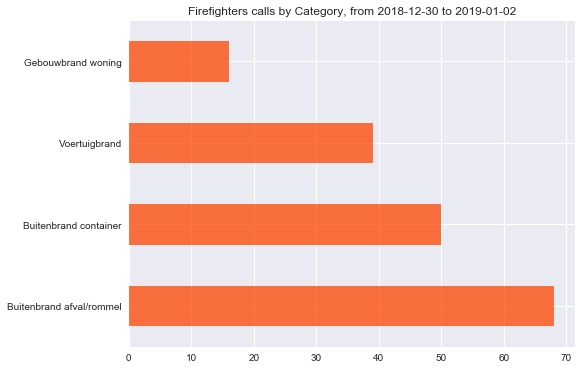

In [18]:
df['pmeCategoryOnly'].value_counts().plot.barh(figsize=(8,6), color='orangered', alpha=.75);
plt.title(f'Firefighters calls by Category, from {begin.date()} to {end.date()}');

In [19]:
t = gdf.loc[j,:]
t['pmeCategoryOnly'] = l 

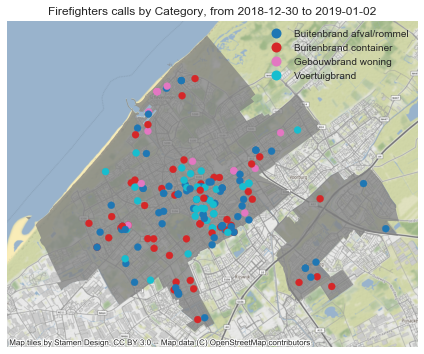

In [20]:
ax = polygon.to_crs(epsg=3857).plot(color='gray', alpha=.75, figsize=(8,6))
t.to_crs(epsg=3857).plot(ax=ax, column='pmeCategoryOnly', legend=True);
ctx.add_basemap(ax=ax)
ax.set_title(f'Firefighters calls by Category, from {begin.date()} to {end.date()}')
plt.axis('off');

In [18]:
import pandas as pd
import geopandas
def prepare_gdf(data):
    """
    Prepare data and convert it to GeoDataFrame
    
    Args:
        data (DataFrame) : Initial raw data set
        
    Returns:
        gdf (GeoDataFrame) : Data set with cleaned and converted coordinates
    
    """
    # Clean the coordinates
    data['pmeLatitude'] = data['pmeLatitude'].replace(to_replace='\\N', value=np.nan)
    data['pmeLongitude'] = data['pmeLongitude'].replace(to_replace='\\N', value=np.nan)

    data['pmeLatitude'] = data['pmeLatitude'].dropna()
    data['pmeLongitude'] = data['pmeLongitude'].dropna()

    data["pmeLatitude"] = data["pmeLatitude"].astype(float)
    data["pmeLongitude"] = data["pmeLongitude"].astype(float)

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        data, geometry=gpd.points_from_xy(data["pmeLongitude"], data["pmeLatitude"])
    )
    gdf.crs = {"init": "epsg:4326"}

    print(f"Total number of records collected with assigned coordinates : {gdf.shape[0]}")
    
    return gdf

def select_ny(data, year, delta=1):
    """
    Select New Year's Eve period of a specific year
    
    Args:
        data (DataFrame or GeoDataFrame) : Complete data set (not sliced by date)
        year (int) : Year of interest
        delta (int) : How many days +- take into account
    
    Returns:
        result (DataFrame or GeoDataFrame) : A subset of a specific year and delta
    """
    if year == 2017:
        begin = pd.to_datetime("2017-01-01")
        end = pd.to_datetime("2017-01-" + str(delta))
        
    else:
        begin = pd.to_datetime(str(year-1) + "-12-" + str(31 - delta))
        end = pd.to_datetime(str(year) + "-01-" + str(1 + delta))
    
    result = data[data["pmeTimeStamp"] > begin]
    result = result[result["pmeTimeStamp"] < end]

    print(f"The number of firefigthers calls made from {begin} to {end} : {result.shape[0]}")
    
    return result

### References